## Handle Imports and Dataset

In [1]:
#Handle Imports
import torch
import numpy as np
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(42)

In [2]:
# Load MNIST dataset as tensors using DataLoader class
batch_size = 128
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

def tensor_to_images(image_tensor, num_images=30, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=6)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

100%|██████████| 9912422/9912422 [00:00<00:00, 139006895.04it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 9077914.71it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 53327972.15it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19579166.26it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## Models

In [21]:
class CNNGenerator(nn.Module):
  """
  Generator orig 64 hidden dim
  """
  def __init__(self,  noise_dimension=10, hidden_dim=16, output_dim=28, im_chan=1):
      super(CNNGenerator, self).__init__()

      self.z_dim = noise_dimension

      self.gen = nn.Sequential(

          self.get_generator_block(noise_dimension,
                                    hidden_dim * 4,
                                    kernel_size=3,
                                    stride=2),

          self.get_generator_block(hidden_dim * 4,
                                    hidden_dim * 2,
                                    kernel_size=4,
                                    stride = 1),

          self.get_generator_block(hidden_dim * 2,
                                    hidden_dim ,
                                    kernel_size=3,
                                    stride = 2,
                                  ),

          self.get_generator_final_block(hidden_dim,
                                          im_chan,
                                          kernel_size=4,
                                          stride=2)


      )


  def get_generator_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0):
      return nn.Sequential(
              nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride, padding),
              nn.BatchNorm2d(output_channel),
              nn.ReLU(inplace=True),
      )


  def get_generator_final_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0):
      return  nn.Sequential(
              nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride, padding),
              nn.Tanh()
          )


  def forward(self, noise):
      x = noise.view(len(noise), self.z_dim, 1, 1)
      return self.gen(x)



In [22]:
class CNNDiscriminator(nn.Module):
  """
  Discriminator
  """
  def __init__(self, input_dimension=784,
               hidden_dim=8,#16
               output_dimension=1,
               im_chan=1):
      super(CNNDiscriminator, self).__init__()
      self.disc = nn.Sequential(
          self.get_disc_block(im_chan,
                                        hidden_dim * 4,
                                        kernel_size=4,
                                        stride=2),

          self.get_disc_block(hidden_dim * 4,
                                        hidden_dim * 8,
                                        kernel_size=4,
                                        stride=2,),

          self.get_disc_final_block(hidden_dim * 8,
                                              1,
                                              kernel_size=4,
                                              stride=2,),

      )


  def get_disc_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0):
      return nn.Sequential(
              nn.Conv2d(input_channel, output_channel, kernel_size, stride, padding),
              nn.BatchNorm2d(output_channel),
              nn.LeakyReLU(0.2, inplace=True)
      )


  def get_disc_final_block(self, input_channel, output_channel, kernel_size, stride = 1, padding = 0):
      return  nn.Sequential(
              nn.Conv2d(input_channel, output_channel, kernel_size, stride, padding),
          )

  def forward(self, image):
      return self.disc(image)

In [5]:
class Generator(nn.Module):
  """
  Generator
  """
  def __init__(self,
               noise_dimension=10,
               hidden_dimension=128,
               output_dimension=784):
    super(Generator, self).__init__()

    self.noise_dim = noise_dimension
    self.hidden_dim = hidden_dimension
    self.output_dim = output_dimension

    self.gen_model = nn.Sequential(
        self.create_layerblock(self.noise_dim, self.hidden_dim),
        self.create_layerblock(self.hidden_dim, 2*self.hidden_dim),
        self.create_layerblock(2*self.hidden_dim, 4*self.hidden_dim),
        self.create_layerblock(4*self.hidden_dim, 8*self.hidden_dim),
        nn.Linear(8*self.hidden_dim, self.output_dim)
    )

  def forward(self, noise):
      return self.gen_model(noise)

  def create_layerblock(self, input_dim, output_dim):
    block = nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU()
    )
    return block



In [6]:
class Discriminator(nn.Module):
  """
  Discriminator
  """
  def __init__(self,
               input_dimension=784,
               hidden_dimension=128,
               output_dimension=1):
    super(Discriminator, self).__init__()

    self.inp_dim = input_dimension
    self.hidden_dim = hidden_dimension
    self.output_dim = output_dimension

    self.disc_model = nn.Sequential(
        self.create_layerblock(self.inp_dim, 8*self.hidden_dim),
        self.create_layerblock(8*self.hidden_dim, 4*self.hidden_dim),
        self.create_layerblock(4*self.hidden_dim, 2*self.hidden_dim),
        self.create_layerblock(2*self.hidden_dim, self.hidden_dim),
        nn.Linear(self.hidden_dim, 1)
    )

  def create_layerblock(self, input_dim, output_dim):
    block = nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(0.2, inplace=True)
    )
    return block

  def forward(self, image):
    return self.disc_model(image)

In [7]:
def getnoise(n_samples, dimension=10, device='cpu'):
  return torch.randn(n_samples, dimension, device=device)

## GAN

In [ ]:
# Hyperparameters for training loop
n_epochs = 210
noise_dimension = 64
lr = 0.00001
display_step = 1500

criterion = nn.BCEWithLogitsLoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Generator & Optimizer for Generator
gen = Generator(noise_dimension).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)

# Discriminator & Optimizer for Discriminator
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [ ]:
def get_disc_loss(gen, disc, criterion, real, num_images, noise_dimension, device):
  noise = getnoise(num_images, dimension=noise_dimension, device=device)
  fake_images = gen(noise)

  #Check fake images, 0 means false
  #Detach images to avoid loss function affecting generator
  fake_images_decision = disc(fake_images.detach())
  disc_fake_loss = criterion(fake_images_decision, torch.zeros_like(fake_images_decision))

  real_images_decision = disc(real)
  disc_real_loss = criterion(real_images_decision, torch.ones_like(real_images_decision))

  disc_loss = (disc_fake_loss + disc_real_loss) / 2
  return disc_loss

def get_gen_loss(gen, disc, criterion, num_images, noise_dimension, device):
  noise = getnoise(num_images, dimension=noise_dimension, device=device)
  fake_images = gen(noise)

  #Check fake images, 0 means false
  #Detach images to avoid loss function affecting generator
  fake_images_decision = disc(fake_images)

  gen_loss = criterion(fake_images_decision, torch.ones_like(fake_images_decision))
  return gen_loss

In [ ]:
"""
gen = Generator(noise_dimension).to(device)
gen.load_state_dict(torch.load('disc_model_checkpoint{cur_step}.pth'))
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device)
disc.load_state_dict(torch.load('disc_model_checkpoint.pth'))
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)
"""

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500: Generator loss: 0.7197140937248881, discriminator loss: 0.6931178443431855


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Generator loss: 0.713602942824364, discriminator loss: 0.6928142277002343


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4500: Generator loss: 0.6945281032721199, discriminator loss: 0.6940257266759875


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6000: Generator loss: 0.6919767918189362, discriminator loss: 0.6936591823101046


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7500: Generator loss: 0.6921397415796924, discriminator loss: 0.6935910106897359


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9000: Generator loss: 0.6924755336046229, discriminator loss: 0.6934530438184735


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

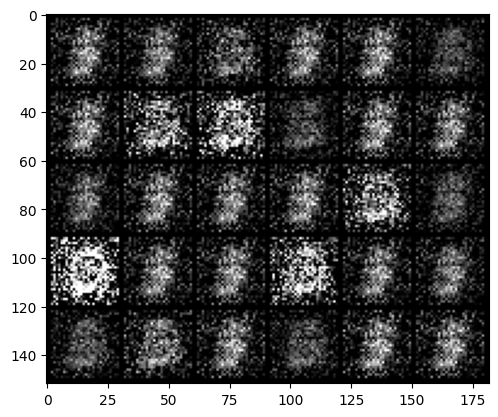

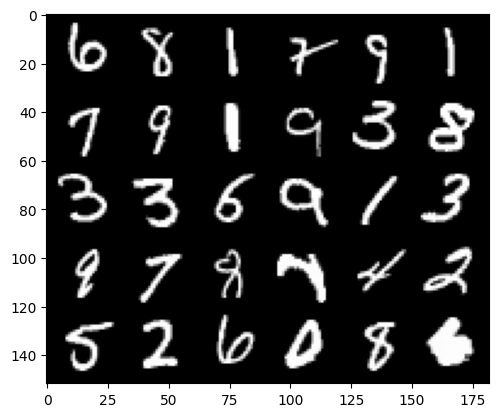

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10500: Generator loss: 0.6931956911881751, discriminator loss: 0.6935237427949903


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12000: Generator loss: 0.6932292606830587, discriminator loss: 0.693403021931649


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13500: Generator loss: 0.6930524539550144, discriminator loss: 0.693336566209794


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15000: Generator loss: 0.6930383812586458, discriminator loss: 0.6933568835258486


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16500: Generator loss: 0.692819449861844, discriminator loss: 0.6933810658454896


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18000: Generator loss: 0.6932757587035498, discriminator loss: 0.6933375233411788


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19500: Generator loss: 0.692995413104693, discriminator loss: 0.6933458844423296


  0%|          | 0/469 [00:00<?, ?it/s]

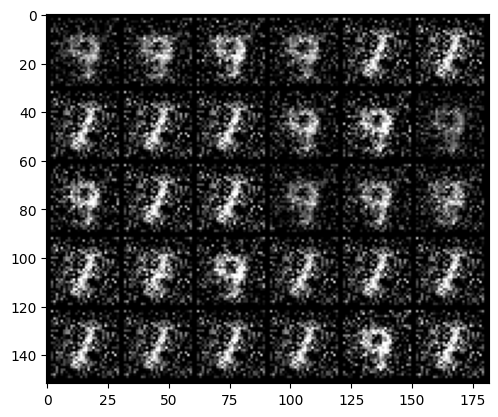

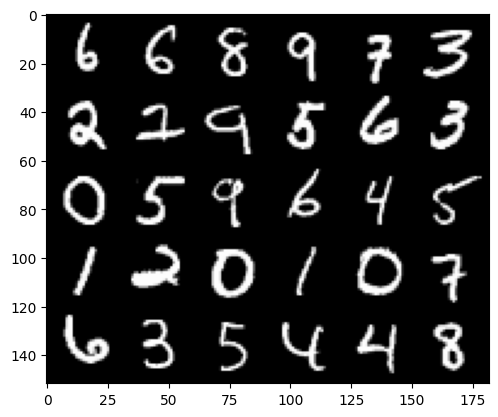

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 21000: Generator loss: 0.6931501242717103, discriminator loss: 0.6933147388696665


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 22500: Generator loss: 0.6933084246714911, discriminator loss: 0.6933729082345956


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 24000: Generator loss: 0.6933573833306624, discriminator loss: 0.6934803366661076


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 25500: Generator loss: 0.6932388587395353, discriminator loss: 0.6933316148519506


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 27000: Generator loss: 0.6930372165441517, discriminator loss: 0.6933301869630809


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 28500: Generator loss: 0.6929857965707779, discriminator loss: 0.6933586031198502


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

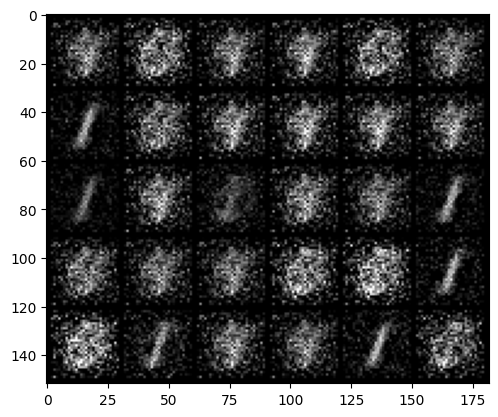

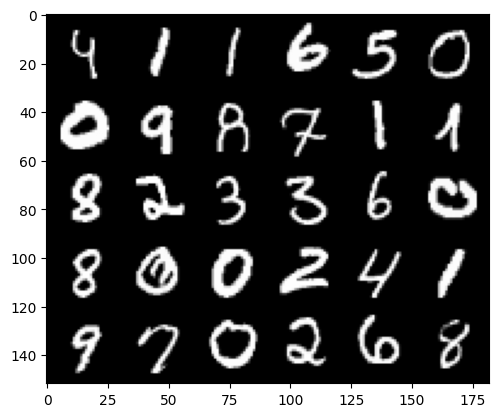

Step 30000: Generator loss: 0.6932192346652356, discriminator loss: 0.6933329741954799


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 31500: Generator loss: 0.693087646245957, discriminator loss: 0.6933790539503101


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 33000: Generator loss: 0.693395627816517, discriminator loss: 0.693244646191597


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 34500: Generator loss: 0.6934476551214844, discriminator loss: 0.6932091150283811


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 36000: Generator loss: 0.6951694374084482, discriminator loss: 0.6929954192638395


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 37500: Generator loss: 0.6938798436323804, discriminator loss: 0.693210866689682


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 39000: Generator loss: 0.6933267321586606, discriminator loss: 0.6928626536130904


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

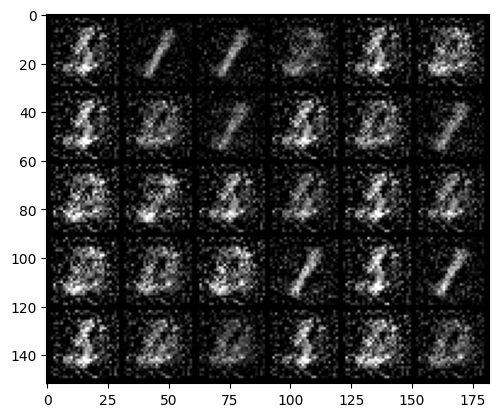

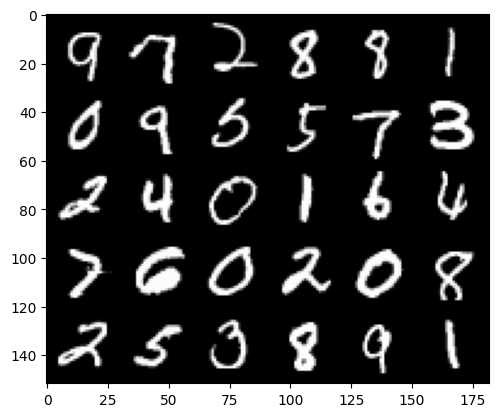

  0%|          | 0/469 [00:00<?, ?it/s]

Step 40500: Generator loss: 0.6954157621860511, discriminator loss: 0.6932480801343927


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 42000: Generator loss: 0.6943184891541799, discriminator loss: 0.6934494488239281


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 43500: Generator loss: 0.6937810806433353, discriminator loss: 0.6940021131038667


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 45000: Generator loss: 0.6951970543464033, discriminator loss: 0.6934177293777468


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 46500: Generator loss: 0.6930832307338716, discriminator loss: 0.6932504694461821


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 48000: Generator loss: 0.6952924195925382, discriminator loss: 0.6934229381084447


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 49500: Generator loss: 0.6914971632560084, discriminator loss: 0.6936652615070347


  0%|          | 0/469 [00:00<?, ?it/s]

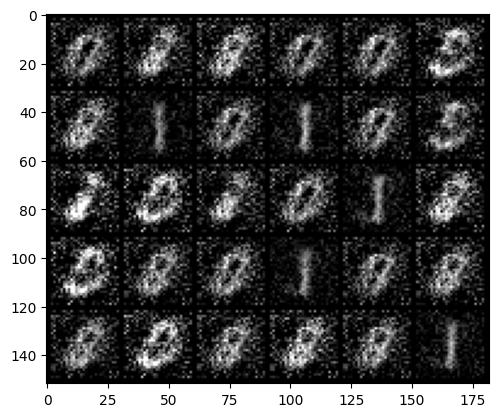

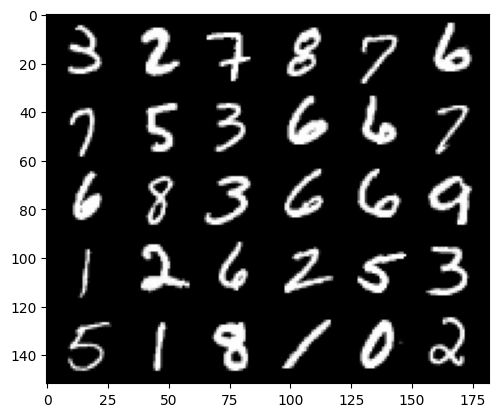

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 51000: Generator loss: 0.6933272238175066, discriminator loss: 0.6934455927610395


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 52500: Generator loss: 0.6968080313603081, discriminator loss: 0.6930811419486996


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 54000: Generator loss: 0.6932263438304261, discriminator loss: 0.6939364993572232


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 55500: Generator loss: 0.6945233907302221, discriminator loss: 0.69338472187519


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 57000: Generator loss: 0.693159264922141, discriminator loss: 0.69329598903656


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 58500: Generator loss: 0.694245609442393, discriminator loss: 0.6934840131998065


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

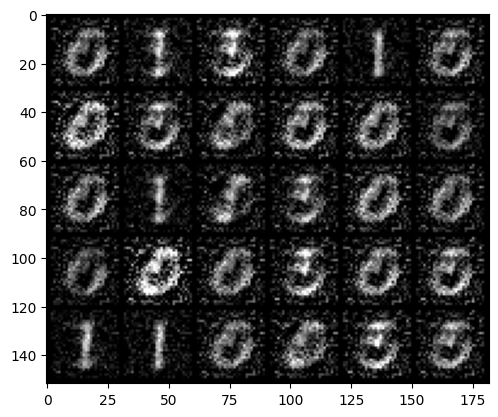

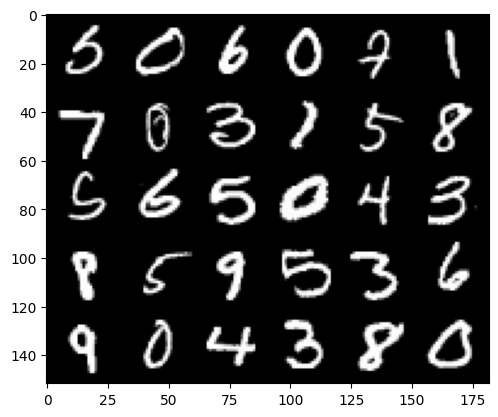

Step 60000: Generator loss: 0.6949052531321844, discriminator loss: 0.6936340035200123


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 61500: Generator loss: 0.6941166271368652, discriminator loss: 0.6934718998670574


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 63000: Generator loss: 0.6980034550031031, discriminator loss: 0.6925772120952601


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 64500: Generator loss: 0.6929982354640976, discriminator loss: 0.6938325928449621


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 66000: Generator loss: 0.6949178903500227, discriminator loss: 0.6925298115015035


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 67500: Generator loss: 0.6969890675544737, discriminator loss: 0.6934572457075123


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 69000: Generator loss: 0.6943452707131703, discriminator loss: 0.69252427661419


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

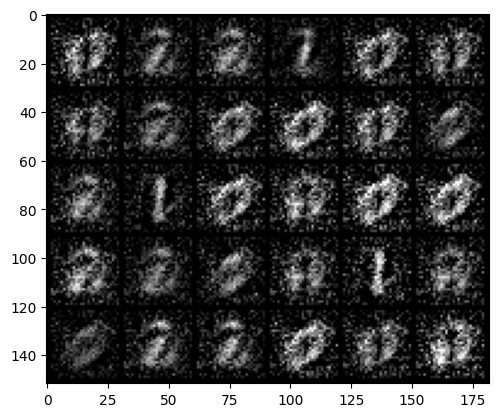

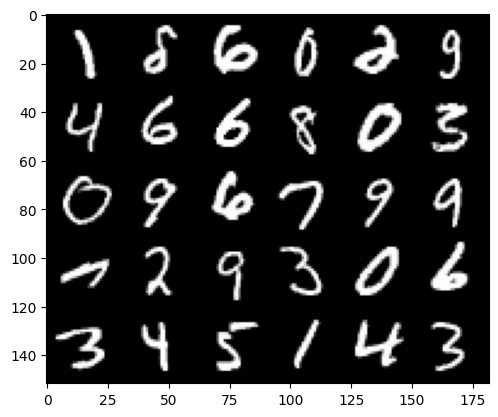

  0%|          | 0/469 [00:00<?, ?it/s]

Step 70500: Generator loss: 0.6945901797215157, discriminator loss: 0.6933696800470349


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 72000: Generator loss: 0.6972034973700845, discriminator loss: 0.6936828124523156


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 73500: Generator loss: 0.6975912168423333, discriminator loss: 0.6910606424808502


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 75000: Generator loss: 0.6918932834466306, discriminator loss: 0.6937122355699537


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 76500: Generator loss: 0.6980752140283584, discriminator loss: 0.6927382755279542


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 78000: Generator loss: 0.7029307889540986, discriminator loss: 0.6877497812509539


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 79500: Generator loss: 0.6999783960183456, discriminator loss: 0.6932448769807821


  0%|          | 0/469 [00:00<?, ?it/s]

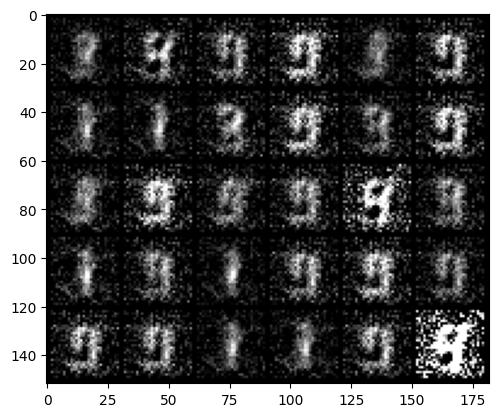

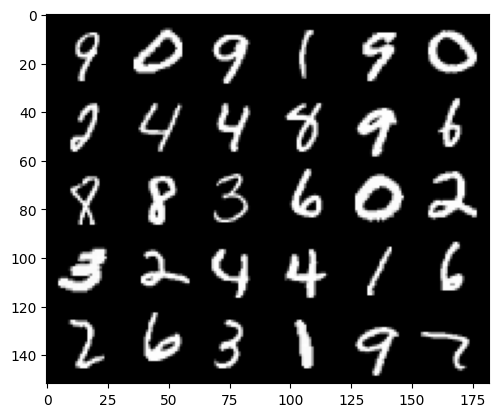

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 81000: Generator loss: 0.7062094567616788, discriminator loss: 0.6910898153781888


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 82500: Generator loss: 0.705639332135518, discriminator loss: 0.6919033143520359


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 84000: Generator loss: 0.6963772699832909, discriminator loss: 0.6927036715745924


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 85500: Generator loss: 0.7009523605902988, discriminator loss: 0.6923974516391749


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 87000: Generator loss: 0.6982274649937956, discriminator loss: 0.691768946528433


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 88500: Generator loss: 0.697453868985177, discriminator loss: 0.6906023713350298


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

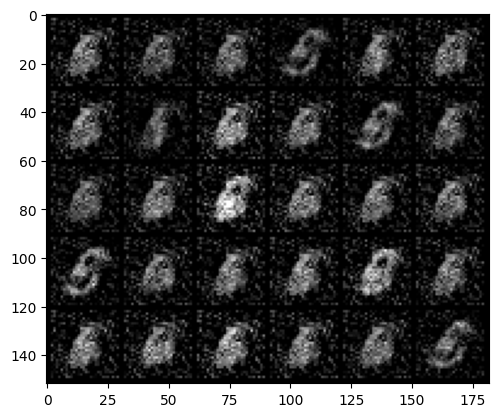

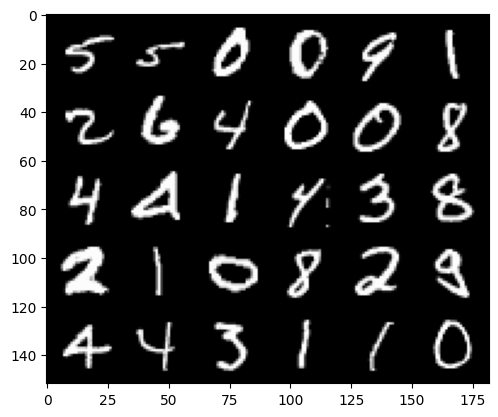

Step 90000: Generator loss: 0.6960604096651078, discriminator loss: 0.6952771644592287


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 91500: Generator loss: 0.7082876285314579, discriminator loss: 0.6911761590242391


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 93000: Generator loss: 0.6966719818512599, discriminator loss: 0.6917551395893107


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 94500: Generator loss: 0.6987801182667414, discriminator loss: 0.6915295145511624


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 96000: Generator loss: 0.710228252251943, discriminator loss: 0.6939997735023499


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 97500: Generator loss: 0.6921721069415412, discriminator loss: 0.6904118479490279


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
gen_loss = False
best_generator_state_dict = None
best_discriminator_state_dict = None
for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):
        # Get number of batch size (number of image)
        # And get tensor for each image in batch
        cur_batch_size = len(real)
        real = real.view(cur_batch_size, -1).to(device)

        ### Traing discriminator ###
        # Zero out the gradient .zero_grad()
        # Calculate discriminator loss get_disc_loss()
        # Update gradient .gradient()
        # Update optimizer .step()
        if cur_step %3 == 0:
          disc_opt.zero_grad()
          disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, noise_dimension, device)
          disc_loss.backward(retain_graph=True)
          disc_opt.step()
          mean_discriminator_loss += disc_loss.item() / (display_step/3)

        ### Traing generator ###
        # Zero out the gradient .zero_grad()
        # Calculate discriminator loss get_gen_loss()
        # Update gradient .gradient()
        # Update optimizer .step()
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, noise_dimension, device)
        gen_loss.backward()
        gen_opt.step()

        mean_generator_loss += gen_loss.item() / display_step
        if cur_step % 10000 == 0 and cur_step >0:
              torch.save(gen.state_dict(), f'gen_model_checkpoint{cur_step}.pth')
              torch.save(disc.state_dict(), f'disc_model_checkpoint{cur_step}.pth')
              fake_noise = getnoise(cur_batch_size, noise_dimension, device=device)
              fake = gen(fake_noise)
              tensor_to_images(fake)
              tensor_to_images(real)
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")


            mean_generator_loss = 0
            mean_discriminator_loss = 0

        cur_step += 1

  0%|          | 0/469 [00:00<?, ?it/s]

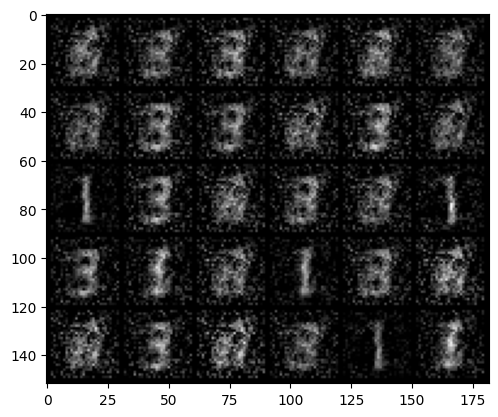

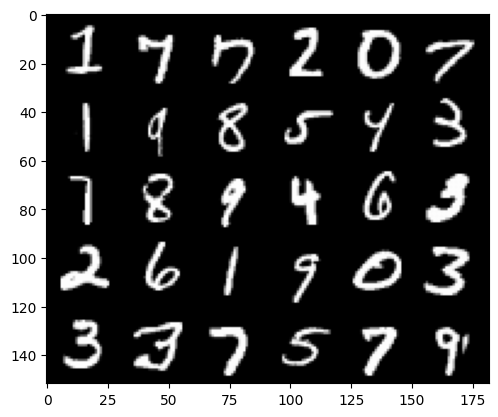

In [ ]:
for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):

              fake_noise = getnoise(cur_batch_size, noise_dimension, device=device)
              fake = gen(fake_noise)
              tensor_to_images(fake)
              tensor_to_images(real)
              break

    break

## Wasserstein Gan

In [ ]:
# Hyperparameters for training loop
n_epochs = 210
noise_dimension = 64
lr = 0.0001
display_step = 469
disc_iterations = 5
weight_clip = 0.01

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Generator & Optimizer for Generator
gen = CNNGenerator(noise_dimension).to(device)
gen_opt = torch.optim.RMSprop(gen.parameters(), lr=lr)

# Discriminator & Optimizer for Discriminator
disc = CNNDiscriminator().to(device)
disc_opt = torch.optim.RMSprop(disc.parameters(), lr=lr)

  0%|          | 0/469 [00:00<?, ?it/s]

Step 39396: Generator loss: -0.011278626300071353, discriminator loss: -0.005644526485520515


  0%|          | 0/469 [00:00<?, ?it/s]

Step 39865: Generator loss: -0.010901942419016724, discriminator loss: -0.0056866745966901635


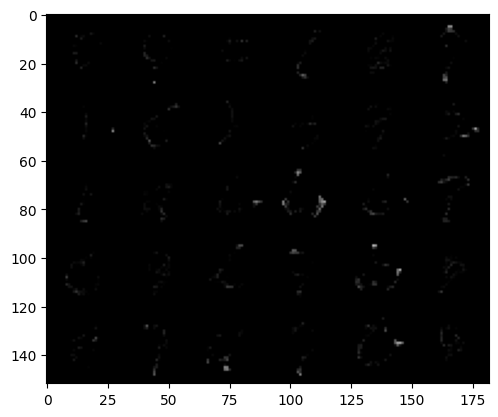

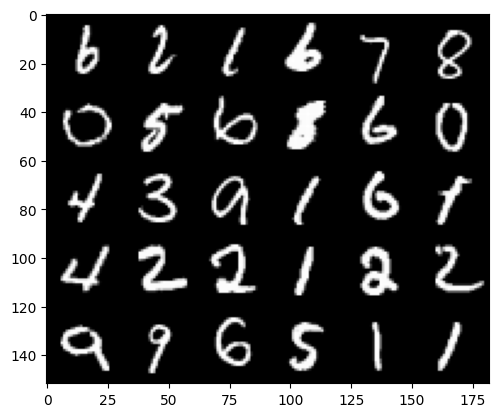

  0%|          | 0/469 [00:00<?, ?it/s]

Step 40334: Generator loss: -0.011091691225013547, discriminator loss: -0.005630967812910517


  0%|          | 0/469 [00:00<?, ?it/s]

Step 40803: Generator loss: -0.011314138994680768, discriminator loss: -0.005556929197265649


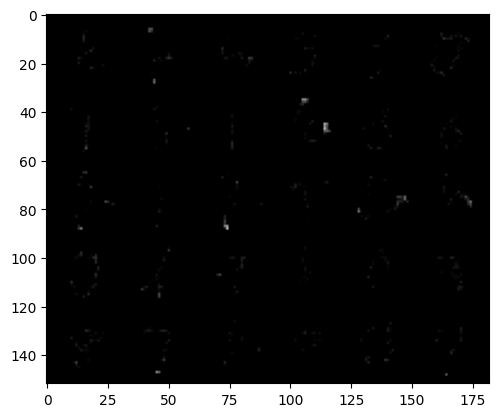

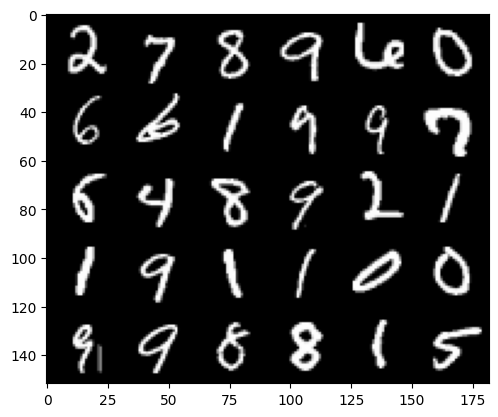

  0%|          | 0/469 [00:00<?, ?it/s]

Step 41272: Generator loss: -0.01092848244583236, discriminator loss: -0.0055448140532993575


  0%|          | 0/469 [00:00<?, ?it/s]

Step 41741: Generator loss: -0.011192489196911263, discriminator loss: -0.005591466884388887


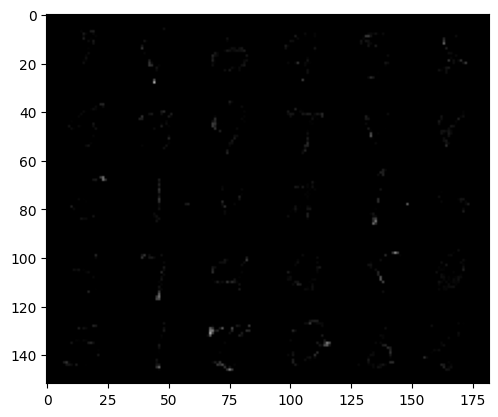

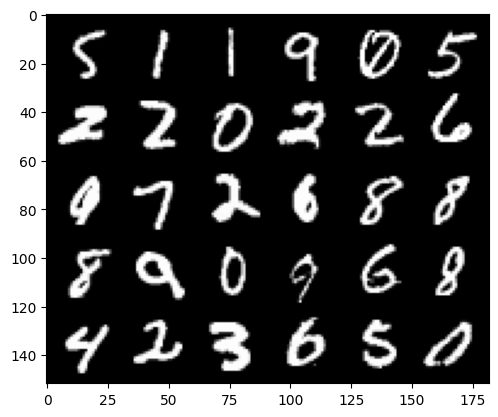

  0%|          | 0/469 [00:00<?, ?it/s]

Step 42210: Generator loss: -0.010843361524849143, discriminator loss: -0.005535569064307223


  0%|          | 0/469 [00:00<?, ?it/s]

Step 42679: Generator loss: -0.011525013751983556, discriminator loss: -0.005431914037820309


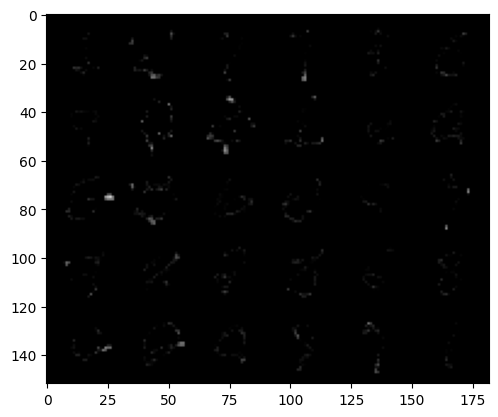

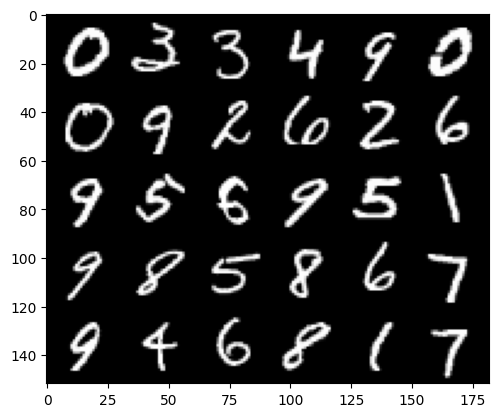

  0%|          | 0/469 [00:00<?, ?it/s]

Step 43148: Generator loss: -0.011417828347584326, discriminator loss: -0.00535169047172438


  0%|          | 0/469 [00:00<?, ?it/s]

Step 43617: Generator loss: -0.011461870373486829, discriminator loss: -0.005387969285762036


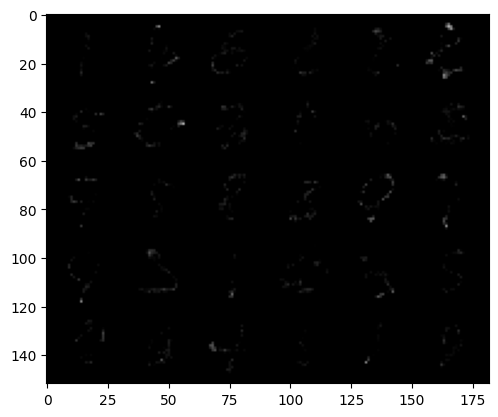

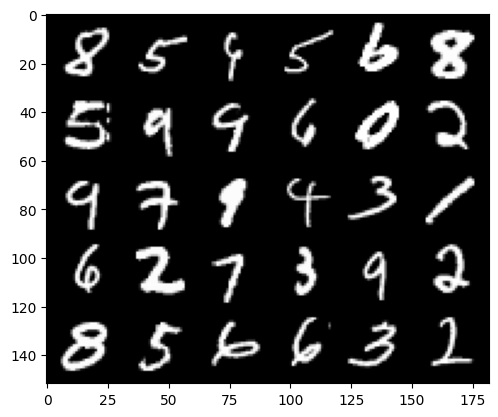

  0%|          | 0/469 [00:00<?, ?it/s]

Step 44086: Generator loss: -0.011285963572754352, discriminator loss: -0.005304800810665695


  0%|          | 0/469 [00:00<?, ?it/s]

Step 44555: Generator loss: -0.01135187884887009, discriminator loss: -0.005324141796567102


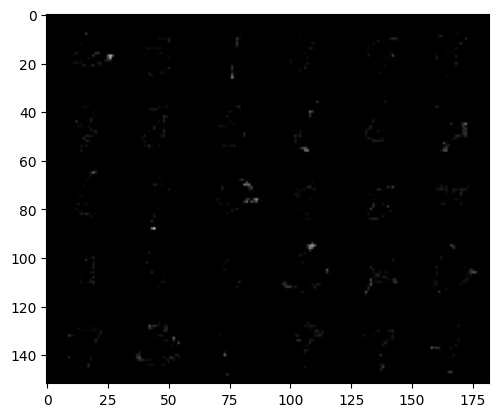

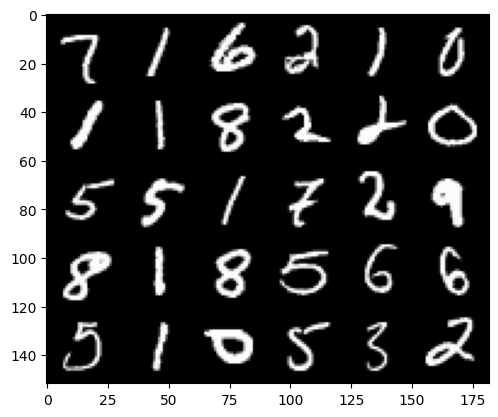

  0%|          | 0/469 [00:00<?, ?it/s]

Step 45024: Generator loss: -0.011657720148962537, discriminator loss: -0.005180125986076972


  0%|          | 0/469 [00:00<?, ?it/s]

Step 45493: Generator loss: -0.011748202108518176, discriminator loss: -0.005237049187845317


  0%|          | 0/469 [00:00<?, ?it/s]

Step 45962: Generator loss: -0.011835228024199038, discriminator loss: -0.0051448988943680425


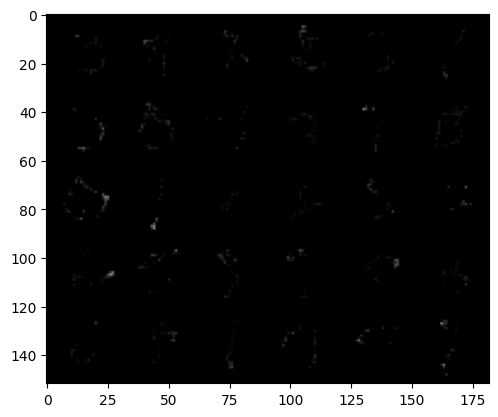

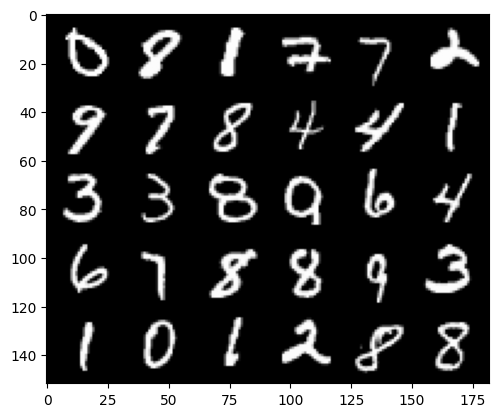

  0%|          | 0/469 [00:00<?, ?it/s]

Step 46431: Generator loss: -0.011736210084986699, discriminator loss: -0.005079864744228053


KeyboardInterrupt: 

In [ ]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
gen_loss = False
best_generator_state_dict = None
best_discriminator_state_dict = None
for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):
        # Get number of batch size (number of image)
        # And get tensor for each image in batch
        cur_batch_size = len(real)
        real = real.to(device)
        # Training discriminator
        for _ in range(disc_iterations):

          noise = getnoise(cur_batch_size, dimension=noise_dimension, device=device)
          fake_images = gen(noise)

          #Check fake images, 0 means false
          fake_images_decision = disc(fake_images.detach()).reshape(-1)#Reshape to 1D
          real_images_decision = disc(real).reshape(-1)
          disc_loss = -( torch.mean(real_images_decision) - torch.mean(fake_images_decision)) # Maximize Distance between Distribution
          disc_opt.zero_grad()
          disc_loss.backward(retain_graph=True)
          disc_opt.step()
        mean_discriminator_loss += disc_loss.item()/display_step

        for p in disc.parameters():
        #Check that parameters are inside an interval (needed for mathematical property, Lipschitz)
          p.data.clamp_(-weight_clip, weight_clip)


        ### Traing generator: min -E[critic(gen_fake)]
        noise = getnoise(cur_batch_size, dimension=noise_dimension, device=device)
        fake_images = gen(noise)
        fake_images_decision = disc(fake_images).reshape(-1)
        gen_loss = -torch.mean(fake_images_decision)
        gen_opt.zero_grad()
        gen_loss.backward()
        gen_opt.step()
        mean_generator_loss += gen_loss.item() / display_step

        if cur_step % 1000 == 0 and cur_step >0:
              torch.save(gen.state_dict(), f'gen_modelws_checkpoint{cur_step}.pth')
              torch.save(disc.state_dict(), f'disc_modelws_checkpoint{cur_step}.pth')
              fake_noise = getnoise(cur_batch_size, noise_dimension, device=device)
              fake = gen(fake_noise)
              tensor_to_images(fake)
              tensor_to_images(real)
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")


            mean_generator_loss = 0
            mean_discriminator_loss = 0

        cur_step += 1

##WassersteinGP (Gradient Penalty) GAN

In [25]:
# Hyperparameters for training loop
n_epochs = 210
noise_dimension = 64 #Reduce noise dimension to 10
lr = 0.0001
display_step = 469
disc_iterations = 5
lambdagp = 10

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [26]:
# Generator & Optimizer for Generator #Maybe change Norm
gen = CNNGenerator(noise_dimension).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)

# Discriminator & Optimizer for Discriminator
disc = CNNDiscriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [27]:
def gradient_penalty(disc, real, fake, device="cpu"):
  Batch_size, C, H, W = real.shape
  epsilon = torch.rand((Batch_size, 1, 1, 1), requires_grad=True).repeat(1,C,H,W).to(device)
  interpolated_images = real * epsilon + fake * (1-epsilon)

  mixed_scores = disc(interpolated_images)

  #Calc Gradient
  gradient = torch.autograd.grad(
      inputs=interpolated_images,
      outputs = mixed_scores,
      grad_outputs=torch.ones_like(mixed_scores),
      create_graph = True,
      retain_graph = True,
      #allow_unused = True,
      #materialize_grads = True
  )[0]
  gradient = gradient.view(gradient.shape[0], -1)
  gradient_norm = gradient.norm(2, dim=1)
  gradient_penalty = torch.mean((gradient_norm-1)**2)
  return gradient_penalty


In [18]:
# Paths to data sets
#Change these Path to the paths where the data is located
GEN_file = ""
DISC_file = ""
#Run this if the data is stored on google drive, to connect to it
from google.colab import drive
drive.mount("/content/gdrive")




Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [19]:
gen.load_state_dict(torch.load(GEN_file))#, map_location=torch.device('cpu')))
disc.load_state_dict(torch.load(DISC_file))#, map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
gen_loss = False
best_generator_state_dict = None
best_discriminator_state_dict = None
for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):
        # Get number of batch size (number of image)
        # And get tensor for each image in batch
        cur_batch_size = len(real)
        real = real.to(device)
        # Training discriminator
        for _ in range(disc_iterations):
          disc_opt.zero_grad()

          noise = getnoise(cur_batch_size, dimension=noise_dimension, device=device)
          fake_images = gen(noise)

          #Check fake images, 0 means false
          #Detach images to avoid loss function affecting generator
          fake_images_decision = disc(fake_images.detach()).reshape(-1)#Reshape to 1D
          real_images_decision = disc(real).reshape(-1)
          gp = gradient_penalty(disc, real, fake_images.detach(), device=device)
          disc_loss = (
              -( torch.mean(real_images_decision) - torch.mean(fake_images_decision)) + lambdagp * gp
          )

          disc_loss.backward(retain_graph=True)
          disc_opt.step()
        mean_discriminator_loss += disc_loss.item()/display_step


        ### Traing generator: min -E[critic(gen_fake)]
        # Zero out the gradient .zero_grad()
        # Calculate discriminator loss get_gen_loss()
        # Update gradient .gradient()
        # Update optimizer .step()

        fake_images_decision = disc(fake_images).reshape(-1)
        gen_loss = -torch.mean(fake_images_decision)
        gen_opt.zero_grad()
        gen_loss.backward()
        gen_opt.step()

        mean_generator_loss += gen_loss.item() / display_step
        if cur_step % 2000 == 0 and cur_step >0:
              torch.save(gen.state_dict(), f'gen_modelwsgp_checkpoint{cur_step}.pth')
              torch.save(disc.state_dict(), f'disc_modelwsgp_checkpoint{cur_step}.pth')
              fake_noise = getnoise(cur_batch_size, noise_dimension, device=device)
              fake = gen(fake_noise)
              tensor_to_images(fake)
              tensor_to_images(real)
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")


            mean_generator_loss = 0
            mean_discriminator_loss = 0

        cur_step += 1